In [1]:
!pip install kagglehub version==0.3.13

ERROR: Could not find a version that satisfies the requirement version==0.3.13 (from versions: 0.1.0, 0.1.1)
ERROR: No matching distribution found for version==0.3.13


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ct-kidney-dataset-normal-cyst-tumor-and-stone' dataset.
Path to dataset files: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone


# Required Imports

In [37]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from PIL import Image, UnidentifiedImageError

# Dataset Path

#Load Dataset and Detect Corrupted Images

In [4]:
data_dir = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Load DataFrame and Detect Corrupted Images

In [5]:
filepath = []
labels = []
corrupted_images = []

for fold in os.listdir(data_dir):
    fold_path = os.path.join(data_dir, fold)
    for f in os.listdir(fold_path):
        file_path = os.path.join(fold_path, f)
        try:
            img = Image.open(file_path)
            img.verify()
            filepath.append(file_path)
            labels.append(fold)
        except (UnidentifiedImageError, OSError):
            corrupted_images.append(file_path)

print(f" Corrupted images detected: {len(corrupted_images)}")

df = pd.DataFrame({'filepath': filepath, 'labels': labels})

🛠️ Corrupted images detected: 0


# Total Number of Images

In [6]:
print(f"\n Total valid images: {len(df)}")


 Total valid images: 12446


# Class Distribution


📈 Class Distribution (%):
labels
Normal    40.79
Cyst      29.80
Tumor     18.34
Stone     11.06
Name: proportion, dtype: float64


/tmp/ipython-input-1756781456.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis', order=df['labels'].value_counts().index)


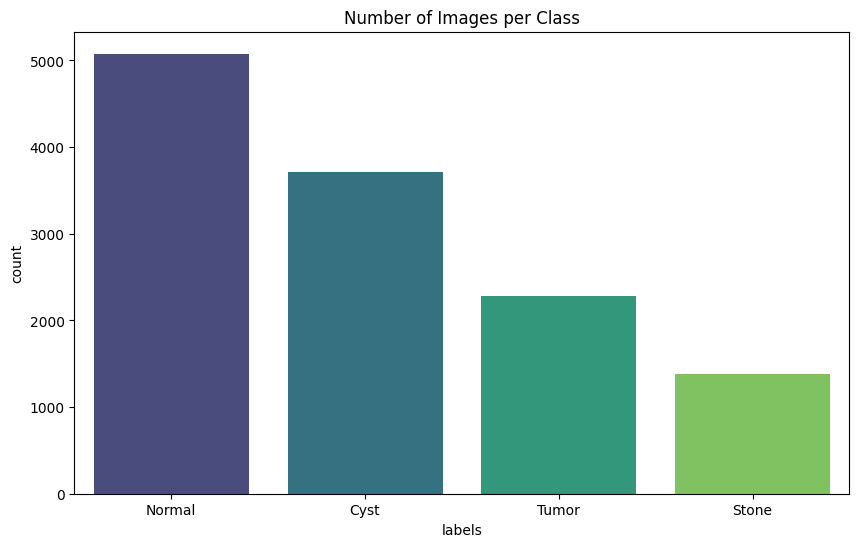

In [ ]:
class_dist = df['labels'].value_counts(normalize=True) * 100
print("\n Class Distribution (%):")
print(class_dist.round(2))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='labels', palette='viridis', order=df['labels'].value_counts().index)
plt.title('Number of Images per Class')
plt.show()

# Display Sample Images

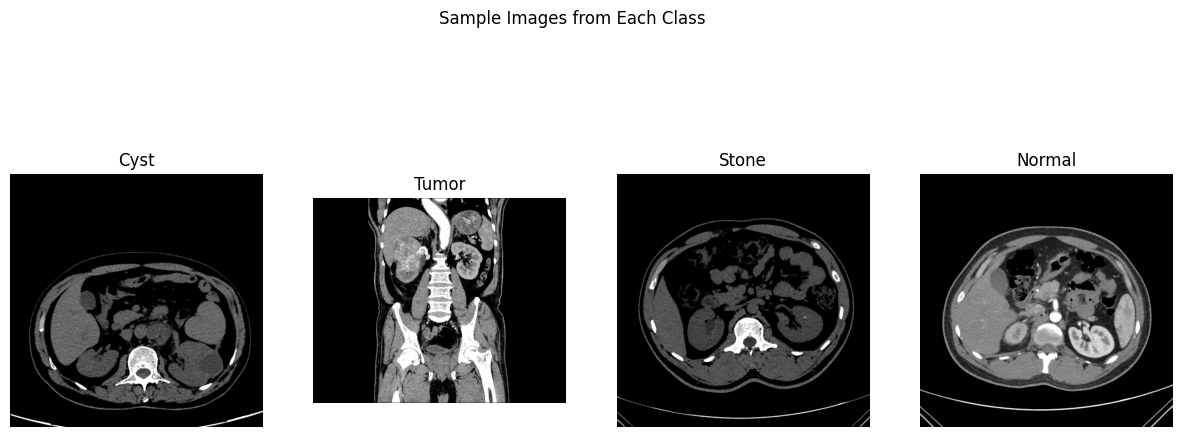

In [7]:
def show_sample_images(df, n=5):
    plt.figure(figsize=(15, 6))
    for i, label in enumerate(df['labels'].unique()):
        sample = df[df['labels'] == label].sample(n=1).iloc[0]
        img = cv2.imread(sample['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(df['labels'].unique()), i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle("Sample Images from Each Class")
    plt.show()

show_sample_images(df)

# Train/Test Split

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)


In [9]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
CLASSES = df['labels'].unique()

# Data Generators

In [10]:
train_aug = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

train_gen = train_aug.flow_from_dataframe(train_df, x_col='filepath', y_col='labels',
                                          target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                          batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')

val_gen = train_aug.flow_from_dataframe(train_df, x_col='filepath', y_col='labels',
                                        target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                        batch_size=BATCH_SIZE, shuffle=False, subset='validation')

test_aug = ImageDataGenerator(rescale=1./255)

test_gen = test_aug.flow_from_dataframe(test_df, x_col='filepath', y_col='labels',
                                        target_size=(IMG_SIZE, IMG_SIZE), class_mode='categorical',
                                        batch_size=BATCH_SIZE, shuffle=False)


Found 7965 validated image filenames belonging to 4 classes.
Found 1991 validated image filenames belonging to 4 classes.
Found 2490 validated image filenames belonging to 4 classes.


# Model Builders

In [44]:
def build_baseline_cnn(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=len(CLASSES),
    optimizer_name='adam',        # e.g., 'adam', 'sgd', 'rmsprop'
    learning_rate=0.001,          # default learning rate
                      # used only if optimizer supports momentum
):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # choose optimizer based on parameter
    optimizer_name = optimizer_name.lower()
    if optimizer_name == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # default to Adam
        opt = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_transfer_model(base_model, learning_rate=1e-4):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Evaluation and Plotting

In [12]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(epochs, history.history['val_accuracy'], marker='o', label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)  # Show all epoch numbers
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], marker='o', label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Show all epoch numbers
    plt.legend()

    plt.show()



# Evaluation

In [13]:

def evaluate_model(model, model_name):
    print(f"\n {model_name} Evaluation")
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    labels = list(test_gen.class_indices.keys())

    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

# **Train & Evaluate All Models**

## **CNN Model**

In [33]:
#  CNN Model

# Using Adam with default lr
model1 = build_baseline_cnn(optimizer_name='adam', learning_rate=0.001)



In [30]:
CNN_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 146s 571ms/step - accuracy: 0.5569 - loss: 1.1142 - val_accuracy: 0.6645 - val_loss: 0.8375
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 142s 571ms/step - accuracy: 0.7150 - loss: 0.7339 - val_accuracy: 0.7941 - val_loss: 0.5433
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 140s 562ms/step - accuracy: 0.7989 - loss: 0.5268 - val_accuracy: 0.8453 - val_loss: 0.4042
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 139s 559ms/step - accuracy: 0.8449 - loss: 0.4061 - val_accuracy: 0.8508 - val_loss: 0.3585
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 569ms/step - accuracy: 0.8818 - loss: 0.3100 - val_accuracy: 0.8970 - val_loss: 0.2640
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 565ms/step - accuracy: 0.9058 - loss: 0.2569 - val_accuracy: 0.9031 - val_loss: 0.2468
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 565ms/step - accuracy: 0.9174 - loss: 0.2205 - val_accuracy: 0.9327 - val_loss: 0.1727
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 141s 568ms/step - accuracy: 0.9314 -

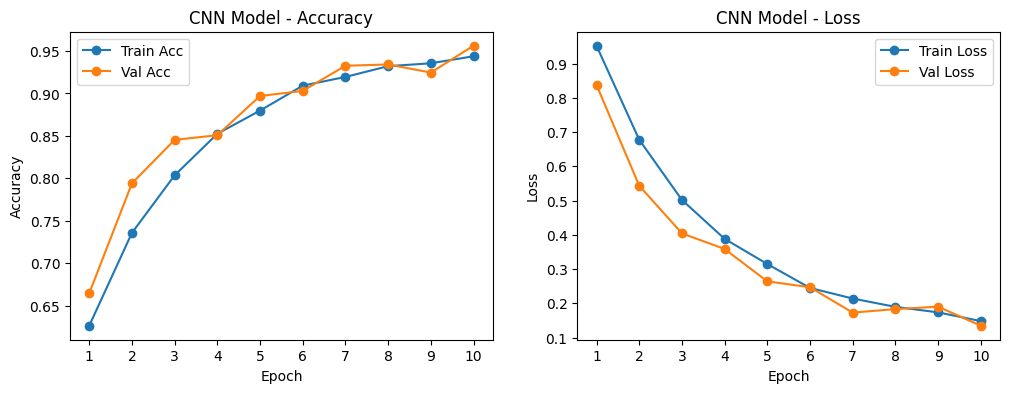

In [34]:
import time
start_train = time.time()
history = model1.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")
plot_history(history, "CNN Model")



 CNN Model with Adam Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step
              precision    recall  f1-score   support

        Cyst       0.97      0.99      0.98       742
      Normal       0.97      0.98      0.98      1016
       Stone       0.97      0.92      0.94       275
       Tumor       0.96      0.94      0.95       457

    accuracy                           0.97      2490
   macro avg       0.97      0.96      0.96      2490
weighted avg       0.97      0.97      0.97      2490



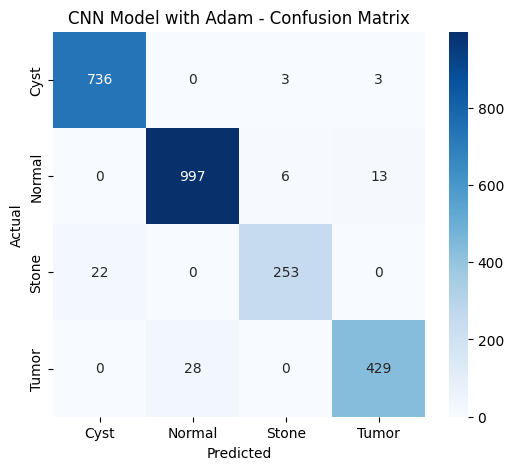

Testing time: 11.15 seconds


In [51]:

# Testing / evaluation
start_test = time.time()
evaluate_model(model1, "CNN Model with Adam")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")

In [45]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
# Using SGD with a higher learning rate
model2 = build_baseline_cnn(optimizer_name='sgd', learning_rate=0.01)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 145s 575ms/step - accuracy: 0.4922 - loss: 1.1754 - val_accuracy: 0.6394 - val_loss: 0.9194
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 553ms/step - accuracy: 0.6264 - loss: 0.9573 - val_accuracy: 0.6474 - val_loss: 0.9156
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 555ms/step - accuracy: 0.6553 - loss: 0.8843 - val_accuracy: 0.6851 - val_loss: 0.8076
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 137s 550ms/step - accuracy: 0.6657 - loss: 0.8344 - val_accuracy: 0.7102 - val_loss: 0.7480
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 139s 558ms/step - accuracy: 0.7032 - loss: 0.7827 - val_accuracy: 0.6544 - val_loss: 0.8177
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 137s 552ms/step - accuracy: 0.7031 - loss: 0.7566 - val_accuracy: 0.7152 - val_loss: 0.7168
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 137s 551ms/step - accuracy: 0.7280 - loss: 0.6884 - val_accuracy: 0.7459 - val_loss: 0.6504
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 554ms/step - accuracy: 0.7429 -

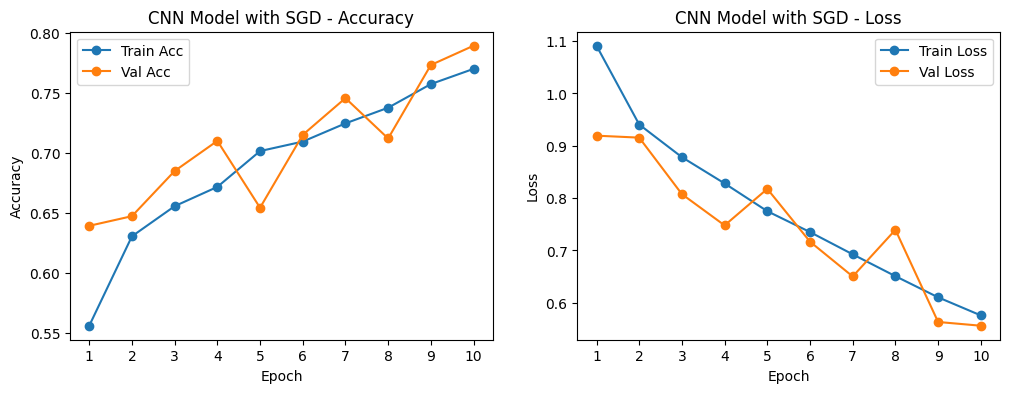

In [46]:
import time
start_train = time.time()
history = model2.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")
plot_history(history, "CNN Model with SGD")



 CNN Model with SGD Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 62s 792ms/step
              precision    recall  f1-score   support

        Cyst       0.79      0.98      0.88       742
      Normal       0.94      0.86      0.90      1016
       Stone       0.83      0.40      0.54       275
       Tumor       0.75      0.85      0.80       457

    accuracy                           0.84      2490
   macro avg       0.83      0.77      0.78      2490
weighted avg       0.85      0.84      0.83      2490



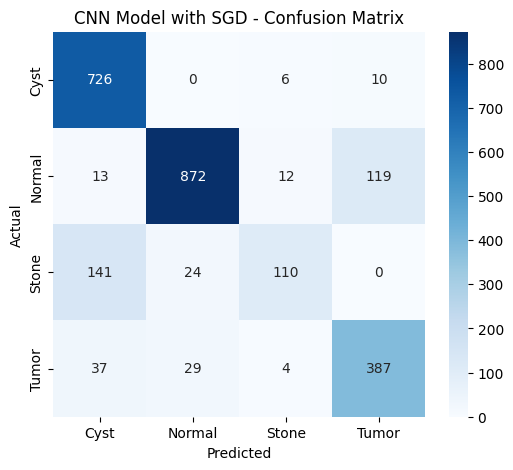

Testing time: 63.69 seconds


In [52]:

# Testing / evaluation
start_test = time.time()
evaluate_model(model2, "CNN Model with SGD")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")

In [48]:

# Using RMSprop
model3 = build_baseline_cnn(optimizer_name='rmsprop')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 143s 562ms/step - accuracy: 0.4879 - loss: 1.5884 - val_accuracy: 0.6419 - val_loss: 0.9596
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 136s 548ms/step - accuracy: 0.6740 - loss: 0.8211 - val_accuracy: 0.6891 - val_loss: 0.7740
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 556ms/step - accuracy: 0.7618 - loss: 0.6052 - val_accuracy: 0.7087 - val_loss: 0.7161
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 555ms/step - accuracy: 0.8110 - loss: 0.4836 - val_accuracy: 0.8192 - val_loss: 0.4716
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 555ms/step - accuracy: 0.8462 - loss: 0.3966 - val_accuracy: 0.8975 - val_loss: 0.2848
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 137s 550ms/step - accuracy: 0.8756 - loss: 0.3282 - val_accuracy: 0.9011 - val_loss: 0.2673
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 553ms/step - accuracy: 0.8927 - loss: 0.2716 - val_accuracy: 0.8086 - val_loss: 0.4504
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 138s 555ms/step - accuracy: 0.9110 -

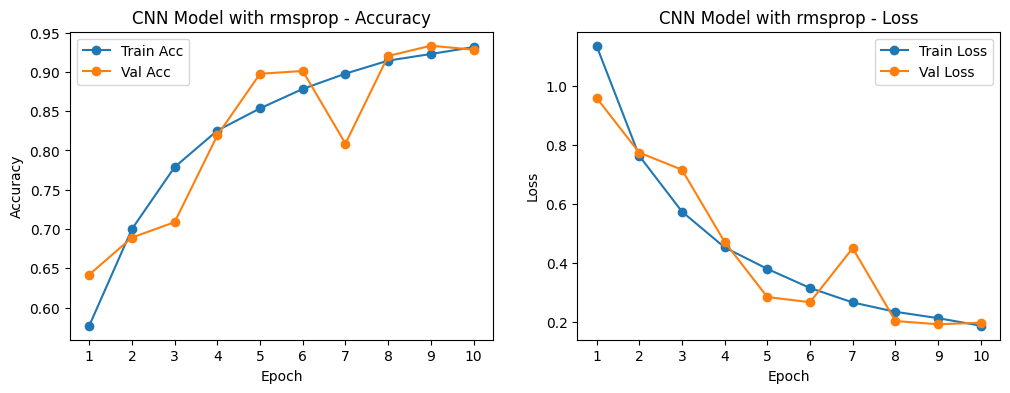

In [49]:
import time
start_train = time.time()
history = model3.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")
plot_history(history, "CNN Model with rmsprop")



 CNN Model with rmsprop Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step
              precision    recall  f1-score   support

        Cyst       0.92      0.94      0.93       742
      Normal       0.94      0.97      0.96      1016
       Stone       1.00      0.52      0.68       275
       Tumor       0.82      0.98      0.90       457

    accuracy                           0.91      2490
   macro avg       0.92      0.85      0.87      2490
weighted avg       0.92      0.91      0.91      2490



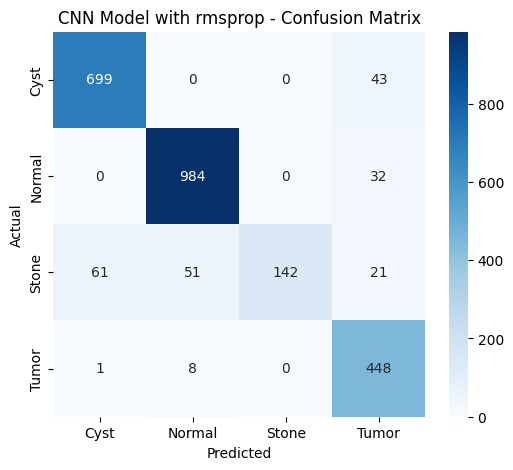

Testing time: 10.27 seconds


In [50]:

# Testing / evaluation
start_test = time.time()
evaluate_model(model3, "CNN Model with rmsprop")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.7387 - loss: 0.7078 - val_accuracy: 0.9121 - val_loss: 0.2488
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 163s 656ms/step - accuracy: 0.9781 - loss: 0.0687 - val_accuracy: 0.9242 - val_loss: 0.1908
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 168s 672ms/step - accuracy: 0.9857 - loss: 0.0455 - val_accuracy: 0.9975 - val_loss: 0.0118
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 165s 663ms/step - accuracy: 0.9921 - loss: 0.0258 - val_accuracy: 0.9985 - val_loss: 0.0067
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 161s 645ms/step - accuracy: 0.9942 - loss: 0.0174 - val_accuracy: 0.9985 - val_loss: 0.0056
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 164s 658ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9940 - val_loss: 0.0180
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9985 - val_loss: 0.0035
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - accuracy: 0.9959 - lo

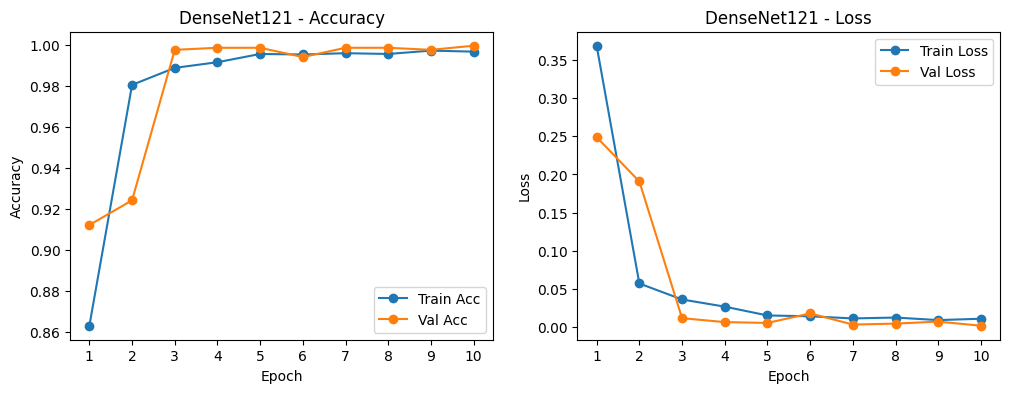


 DenseNet121 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 38s 336ms/step
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      1.00      1.00       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



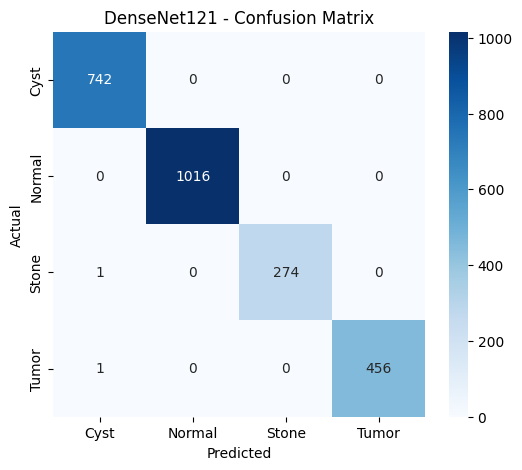

Testing time: 42.26 seconds


In [54]:
import time
# DenseNet121
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_densenet = build_transfer_model(base_densenet)

# Training
start_train = time.time()
history = model_densenet.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")

plot_history(history, "DenseNet121")

# Testing / evaluation
start_test = time.time()
evaluate_model(model_densenet, "DenseNet121")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 311s 884ms/step - accuracy: 0.6767 - loss: 0.8123 - val_accuracy: 0.2240 - val_loss: 1.4879
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 148s 596ms/step - accuracy: 0.9472 - loss: 0.1676 - val_accuracy: 0.1587 - val_loss: 1.6040
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 152s 609ms/step - accuracy: 0.9752 - loss: 0.0757 - val_accuracy: 0.3521 - val_loss: 1.4893
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 151s 607ms/step - accuracy: 0.9855 - loss: 0.0427 - val_accuracy: 0.3179 - val_loss: 1.8265
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 148s 595ms/step - accuracy: 0.9909 - loss: 0.0307 - val_accuracy: 0.2707 - val_loss: 1.5832
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 148s 592ms/step - accuracy: 0.9891 - loss: 0.0319 - val_accuracy: 0.6268 - val_loss: 1.0062
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 147s 589ms/step - accuracy: 0.9923 - loss: 0.0244 - val_accuracy: 0.2752 - val_loss: 1.6176
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 146s 584ms/step - accuracy: 0.9935 -

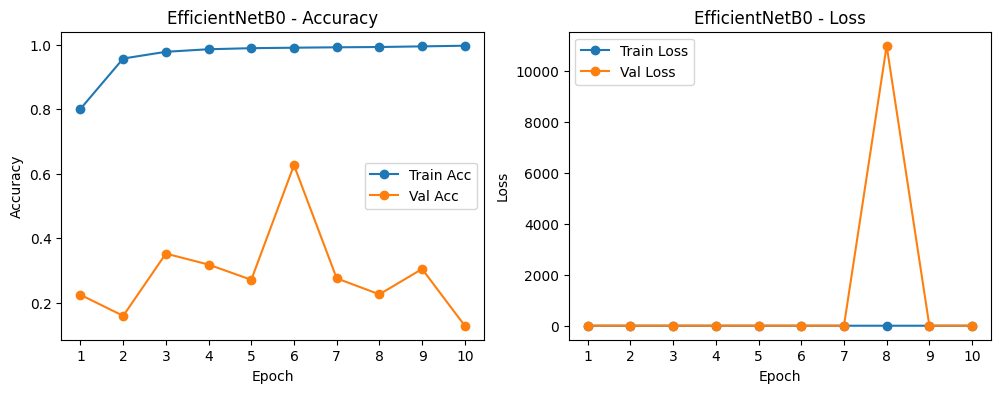


 EfficientNetB0 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step
              precision    recall  f1-score   support

        Cyst       0.64      0.13      0.22       742
      Normal       0.00      0.00      0.00      1016
       Stone       0.11      0.95      0.20       275
       Tumor       0.00      0.00      0.00       457

    accuracy                           0.14      2490
   macro avg       0.19      0.27      0.10      2490
weighted avg       0.20      0.14      0.09      2490



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


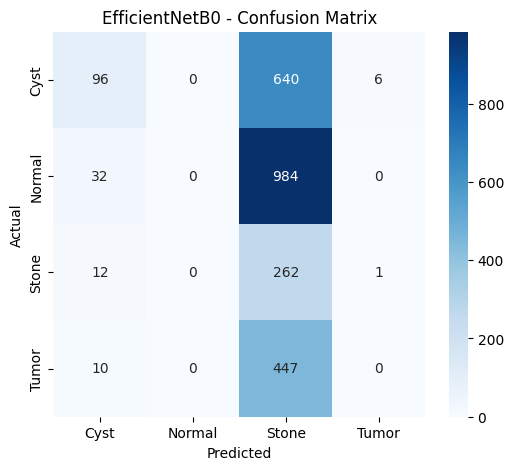

Testing time: 29.80 seconds


In [56]:
import time
# EfficientNetB0
base_efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_efficient = build_transfer_model(base_efficient)

# Training
start_train = time.time()
history = model_efficient.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")

plot_history(history, "EfficientNetB0")

# Testing / evaluation
start_test = time.time()
evaluate_model(model_efficient, "EfficientNetB0")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 259s 800ms/step - accuracy: 0.7916 - loss: 0.5352 - val_accuracy: 0.4114 - val_loss: 1.3806
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 163s 654ms/step - accuracy: 0.9769 - loss: 0.0672 - val_accuracy: 0.1296 - val_loss: 2.3456
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 163s 654ms/step - accuracy: 0.9915 - loss: 0.0288 - val_accuracy: 0.1251 - val_loss: 5.4685
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 164s 660ms/step - accuracy: 0.9865 - loss: 0.0313 - val_accuracy: 0.4274 - val_loss: 2.9003
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 165s 661ms/step - accuracy: 0.9936 - loss: 0.0213 - val_accuracy: 0.9317 - val_loss: 0.2172
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 166s 667ms/step - accuracy: 0.9888 - loss: 0.0359 - val_accuracy: 0.9915 - val_loss: 0.0349
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 205s 678ms/step - accuracy: 0.9940 - loss: 0.0197 - val_accuracy: 0.9925 - val_loss: 0.0207
Epoch 8/10
249/249 ━━━━━━

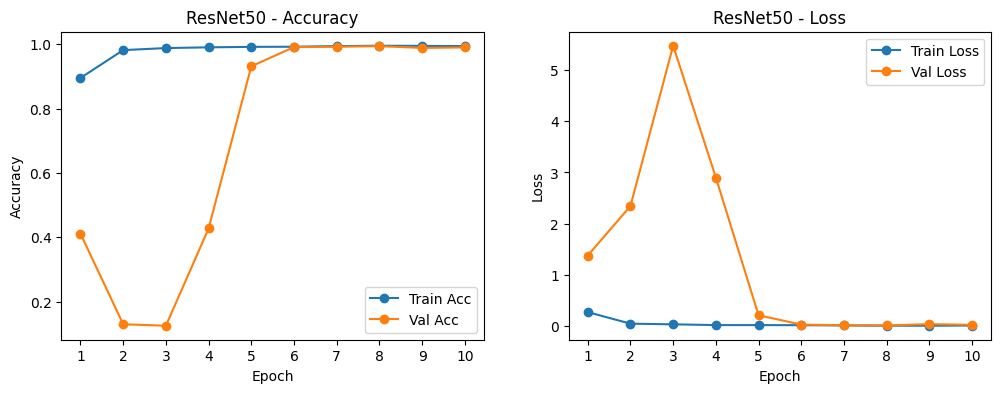


 ResNet50 Evaluation
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step
              precision    recall  f1-score   support

        Cyst       0.96      1.00      0.98       742
      Normal       1.00      0.98      0.99      1016
       Stone       0.93      0.94      0.94       275
       Tumor       1.00      0.97      0.98       457

    accuracy                           0.98      2490
   macro avg       0.97      0.97      0.97      2490
weighted avg       0.98      0.98      0.98      2490



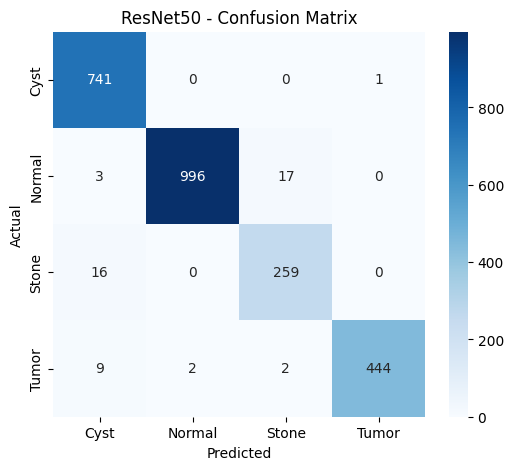

Testing time: 21.82 seconds


In [57]:
import time


# ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_resnet = build_transfer_model(base_resnet)

# Training
start_train = time.time()
history = model_resnet.fit(train_gen, validation_data=val_gen, epochs=10)
end_train = time.time()
print(f"Training time: {(end_train-start_train):.2f} seconds")

plot_history(history, "ResNet50")

# Testing / evaluation
start_test = time.time()
evaluate_model(model_resnet, "ResNet50")
end_test = time.time()
print(f"Testing time: {(end_test-start_test):.2f} seconds")